# Library Import

In [2]:
import pandas as pd
import numpy as np
import ripser
from persim import plot_diagrams
import networkx as nx
import matplotlib.pyplot as plt
import random
from sklearn.cluster import DBSCAN
import gudhi as gd
import math

## Construct Dataset and Set Filtration

In [3]:
# Create a dummy protein-protein interaction dataset

data = {
    'Protein1': ['A', 'A', 'B', 'B', 'C', 'D', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q'],
    'Protein2': ['B', 'C', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'A', 'B', 'C'],
    'Weight': [0.8, 0.9, 0.8, 0.5, 0.5, 0.6, 0.7, 0.8, 0.9, 0.8, 0.6, 0.5, 0.7, 0.6, 0.9, 0.8, 0.5, 0.6, 0.7, 0.8]
}

ppi_df = pd.DataFrame(data)

# Create a dummy protein complex dataset
complexes = [['A', 'B', 'C'], ['D', 'E', 'F'], ['G', 'H', 'I', 'J'], ['K', 'L'], ['M', 'N', 'O'], ['P', 'Q']]


# Define the filtration parameter based on edge weights
filtration_parameter = 'Weight'


In [88]:
## RANDOMIZED Network construction based on a given edge presence probability

# Initializing empty graph with the Networkx Package
protein_network = nx.Graph()

# Adding 100 proteins as nodes
proteins = [f"Protein_{i}" for i in range(1, 1001)]
protein_network.add_nodes_from(proteins)

# Adding some randomization by assigning a probability parameter for edge creation
edge_probability = 0.15

# Assigning random weights to edges with given probability
for i, protein1 in enumerate(proteins):
    for j, protein2 in enumerate(proteins):
        if i < j and random.random() < edge_probability:  # Ensuring to add only one side of the edge to avoid duplicates and self-loops
            # Assigning random weights for edges
            protein_network.add_edge(protein1, protein2, weight=random.uniform(0.0, 0.8))


In [82]:
## PARETO DISTRIBUTION NODE DEGREE NETWORK



# Initializing empty graph with the Networkx Package
protein_network = nx.Graph()

# Adding 100 proteins as nodes
proteins = [f"Protein_{i}" for i in range(1, 1001)]
protein_network.add_nodes_from(proteins)

# Parameters for Pareto distribution
minimum = 1  # Minimum degree in the network
alpha = 2.5  # Shape parameter of the Pareto distribution

# Generate node degrees based on the Pareto distribution
degrees = np.random.pareto(alpha, len(proteins)) + minimum

# Assign edges based on the degree distribution
for i, protein1 in enumerate(proteins):
    for j, protein2 in enumerate(proteins):
        if i < j and random.random() < (degrees[i] * degrees[j]) / (len(proteins) * (len(proteins) - 1)):
            # Assigning random weights for edges
            protein_network.add_edge(protein1, protein2, weight=random.uniform(0.0, 0.8))


In [89]:
# Creating protein complexes (connecting nodes within complexes with higher weights)
complex_1 = random.sample(proteins, 30)
complex_2 = random.sample(proteins, 20)
complex_3 = random.sample(proteins, 10)

# Assigning higher weights to edges between proteins that belong in the complexes
for complex_proteins in [complex_1, complex_2, complex_3]:
    for i in range(len(complex_proteins)):
        for j in range(i+1, len(complex_proteins)):
            if protein_network.has_edge(complex_proteins[i], complex_proteins[j]):
                ## For each protein belonging to a complex double the edge weight to indicate stronger interaction
                if protein_network[complex_proteins[i]][complex_proteins[j]]['weight'] >= 0.5:
                    protein_network[complex_proteins[i]][complex_proteins[j]]['weight'] = 0.95
                else:
                    protein_network[complex_proteins[i]][complex_proteins[j]]['weight'] *= 2  

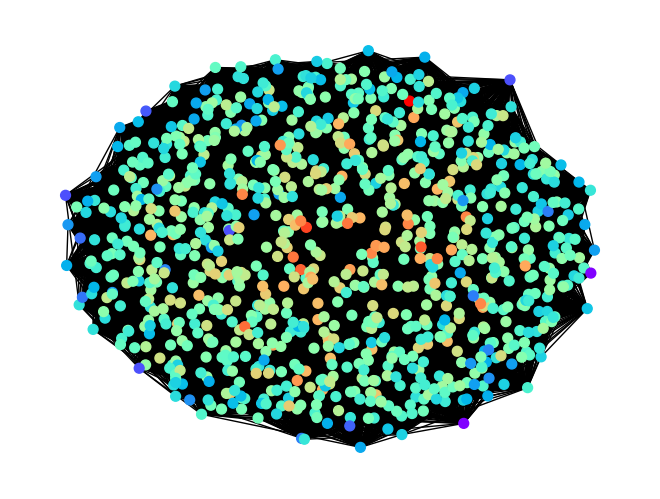

In [90]:
scaled_degree = [d[1]*50 for d in nx.degree(protein_network)]
nx.draw_spring(protein_network,
        # Weights Based on Column
        #width=list(nx.get_edge_attributes(protein_network, 'SemSim').values()),
        # Node size based on degree
        node_size=50,
        # Colour Based on Degree
        node_color=scaled_degree,
        # Set color map to determine colours
        cmap='rainbow',
        with_labels=False)

## Node Degree Viualization

In [91]:
## The following is just to check the distribution of the node degrees. As it seems like there are highly central nodes
degree_nodes = {}
for p, d in protein_network.degree():
  degree_nodes[p] = d

## This gives that there are nodes with degree > 900
sorted_node_degrees = dict(sorted(degree_nodes.items(), key=lambda item: item[1],  reverse=True))


In [92]:
## Let's visualize the distribution
viz_degree = {degree: 0 for degree in degree_nodes.values()}
for degree in degree_nodes.values():
  viz_degree[degree]+=1

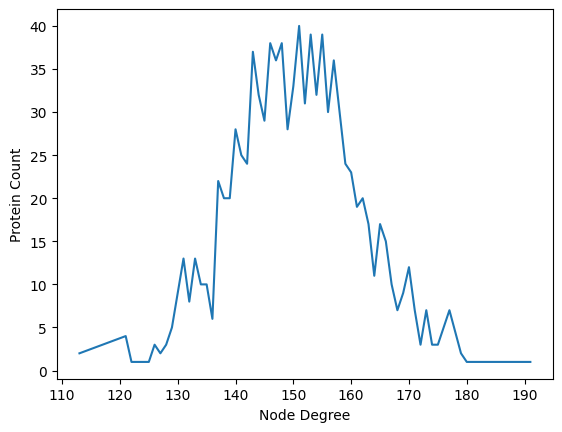

In [93]:
degree_count_pairs = sorted(viz_degree.items())
x, y = zip(*degree_count_pairs) # unpack a list of pairs into two tuples
plt.plot(x, y)
plt.xlabel('Node Degree')
plt.ylabel('Protein Count')
plt.show()

# Construct Network

In [ ]:
# Create a graph from the PPI dataset
G = nx.Graph()
for index, row in ppi_df.iterrows():
    G.add_edge(row['Protein1'], row['Protein2'], weight=row['Weight'])

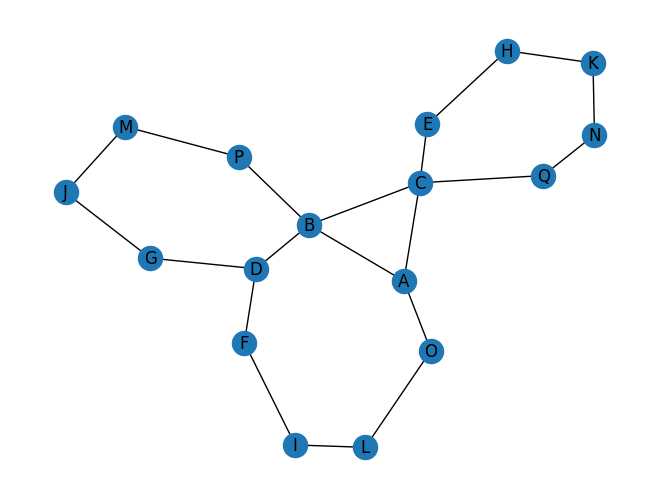

In [ ]:
nx.draw_kamada_kawai(G, with_labels=True)

# Persistent Homology

## Vietoris Rips Filtration with Ripser

In [ ]:
## Using the distance to consider the network as a metric space takes away from the features that could be extracted from the edge weights
## we could see how this reflects on the persistence diagrams
D = np.array(nx.floyd_warshall_numpy(G))
distance_mat_diags = ripser.ripser(D, distance_matrix=True, maxdim=3)['dgms']

/opt/homebrew/lib/python3.11/site-packages/ripser/ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(


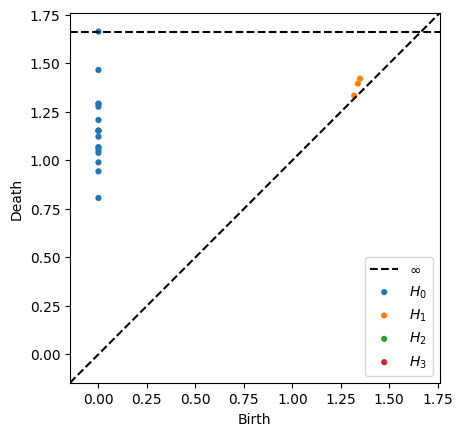

In [ ]:
# Calculate persistent homology using Ripser
adj_mat_diags = ripser.ripser(nx.adjacency_matrix(G).toarray(), distance_matrix=False, maxdim=3)['dgms']
plot_diagrams(adj_mat_diags)

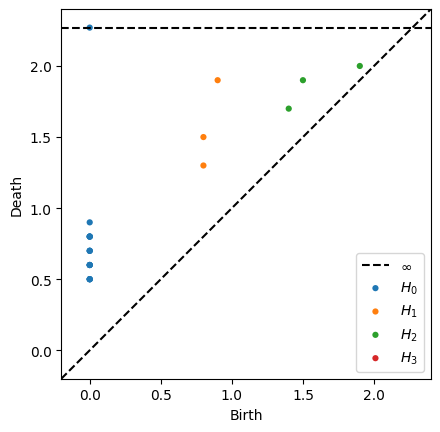

In [ ]:
plot_diagrams(distance_mat_diags)

## Barcode Diagrams

In [7]:
## This is a customized function I wrote to plot the barcode specifically for Ripser package Persistence Diagrams
def plot_barcode(diag, dim, **kwargs):
    #dim = 0
    diag_dim = diag[dim]
    birth = diag_dim[:, 0]; death = diag_dim[:, 1]
    finite_bars = death[death != np.inf]
    if len(finite_bars) > 0:
        inf_end = 2 * max(finite_bars)
    else:
        inf_end = 2
    death[death == np.inf] = inf_end
    plt.figure(figsize=kwargs.get('figsize', (10, 5)))
    for i, (b, d) in enumerate(zip(birth, death)):
        if d == inf_end:
            plt.plot([b, d], [i, i], color='k', lw=kwargs.get('linewidth', 2))
        else:
            plt.plot([b, d], [i, i], color=kwargs.get('color', 'b'), lw=kwargs.get('linewidth', 2))
    plt.title(kwargs.get('title', 'Persistence Barcode'))
    plt.xlabel(kwargs.get('xlabel', 'Filtration Value'))
    plt.yticks([])
    plt.tight_layout()
    plt.show()

## Using Correlation Distance Matrix

In [8]:
pn_adjacency = nx.adjacency_matrix(protein_network).toarray()

In [9]:
np.fill_diagonal(pn_adjacency, 1)
distance_mat = 1 - pn_adjacency
distance_mat

array([[0.        , 0.39136037, 1.        , 1.        , 1.        ,
        0.21332112, 1.        , 1.        , 0.96248462, 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 0.47127744],
       [0.39136037, 0.        , 1.        , 1.        , 0.41184789,
        1.        , 1.        , 1.        , 1.        , 0.31323272,
        1.        , 0.44948925, 1.        , 1.        , 1.        ,
        1.        , 0.27693916, 1.        , 1.        , 1.        ],
       [1.        , 1.        , 0.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 0.74471464, 1.        ,
        0.79265639, 1.        , 0.3975667 , 0.48247988, 1.        ],
       [1.        , 1.        , 1.        , 0.        , 0.05      ,
        0.78813253, 0.29223972, 1.        , 1.        , 1.        ,
        0.95882691, 1.        , 1.        , 1

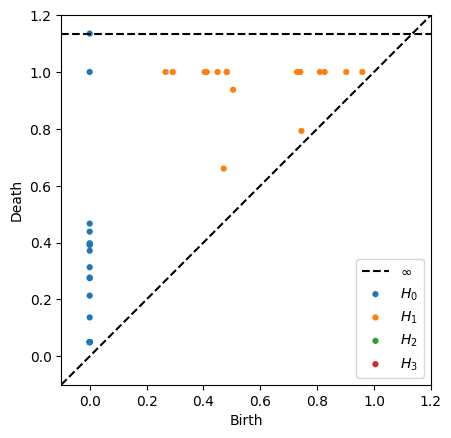

In [10]:
dist_mat_diags_ripser = ripser.ripser(distance_mat, distance_matrix=True, maxdim=3)['dgms']
plot_diagrams(dist_mat_diags_ripser)

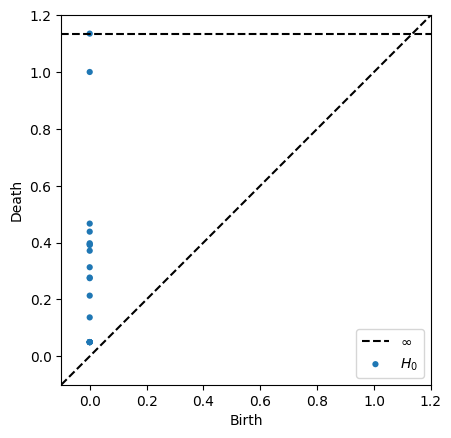

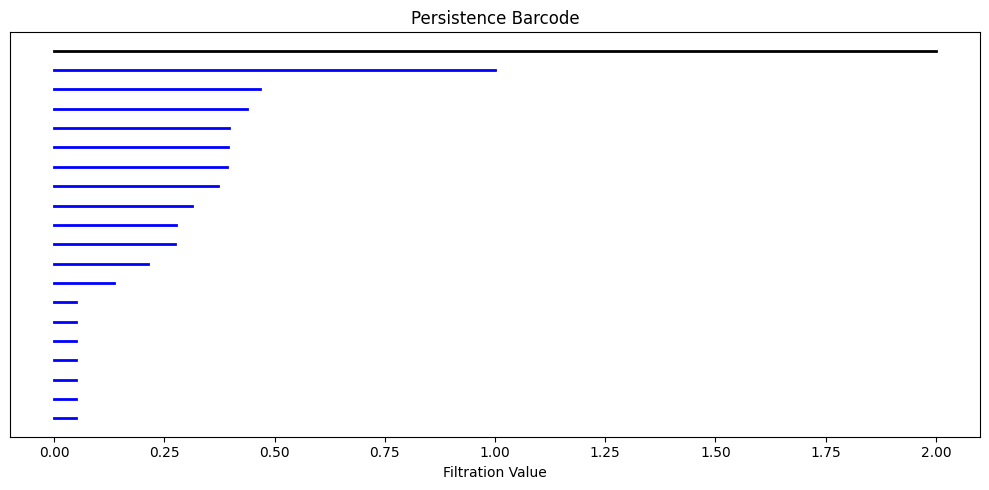

In [11]:
plot_diagrams(dist_mat_diags_ripser, plot_only=[0])
plot_barcode(dist_mat_diags_ripser, 0)

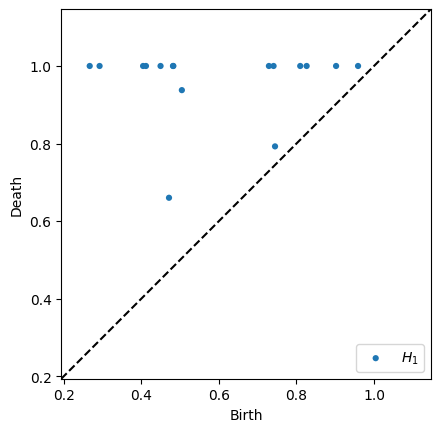

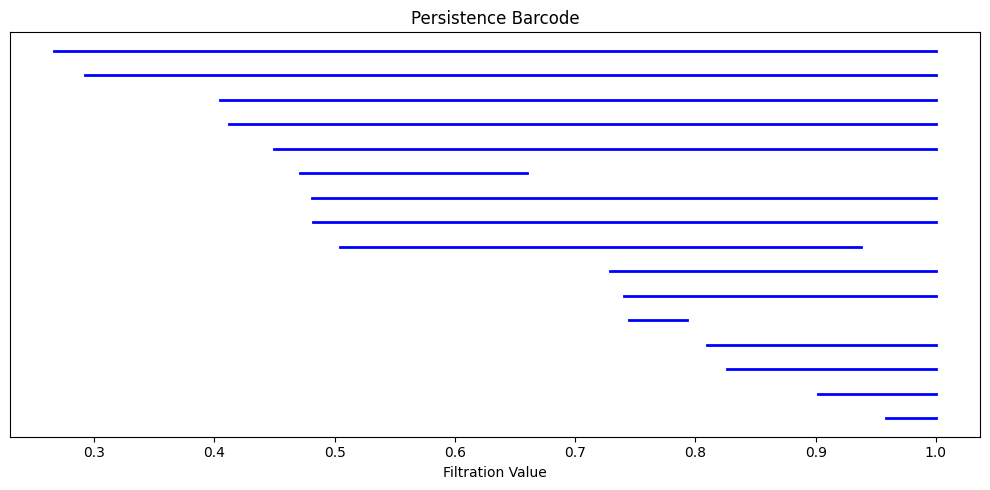

In [12]:
plot_diagrams(dist_mat_diags_ripser, plot_only=[1])
plot_barcode(dist_mat_diags_ripser, 1)

In [14]:
## Let's store the proteins in an indexed dictionary so we could track them back when building the simplex tree
proteins_dict = {protein: idx for idx, protein in enumerate(proteins)}

In [15]:
# Given protein-protein interaction network we can start by creating a simplex tree that includes all 0-simplices (nodes)

# Construct a simplex tree from the network
simplex_tree = gd.SimplexTree()

for edge in protein_network.edges(data=True):
    node1, node2, weight = edge
    ## Get protein index from dict to map it back and feed it into the simplex tree
    node1_idx = proteins_dict[node1]
    node2_idx = proteins_dict[node2]
    simplex_tree.insert([node1_idx, node2_idx], filtration=weight['weight'])



In [31]:
persistence = simplex_tree.persistence(min_persistence=-1, persistence_dim_max=True)

In [29]:
for smplx in simplex_tree.get_filtration():
    print(smplx)

([0], 0.03751537828627463)
([8], 0.03751537828627463)
([0, 8], 0.03751537828627463)
([3], 0.04117308987740734)
([10], 0.04117308987740734)
([3, 10], 0.04117308987740734)
([11], 0.043163193655125026)
([18], 0.043163193655125026)
([11, 18], 0.043163193655125026)
([19], 0.06228556198564501)
([11, 19], 0.06228556198564501)
([12], 0.09576302003480652)
([12, 18], 0.09576302003480652)
([15], 0.09783935992658464)
([16], 0.09783935992658464)
([15, 16], 0.09783935992658464)
([9], 0.17201559652955814)
([8, 9], 0.17201559652955814)
([8, 15], 0.17378214148408164)
([14], 0.1902995182250866)
([3, 14], 0.1902995182250866)
([2], 0.20734360904286975)
([2, 15], 0.20734360904286975)
([5], 0.2118674664470852)
([3, 5], 0.2118674664470852)
([13], 0.255285360551059)
([2, 13], 0.255285360551059)
([9, 12], 0.2590628571416536)
([13, 15], 0.27103902558968207)
([5, 19], 0.3398649156849036)
([17], 0.40825654259134403)
([11, 17], 0.40825654259134403)
([11, 12], 0.4955804639436776)
([11, 16], 0.5063021578933532)
([2,

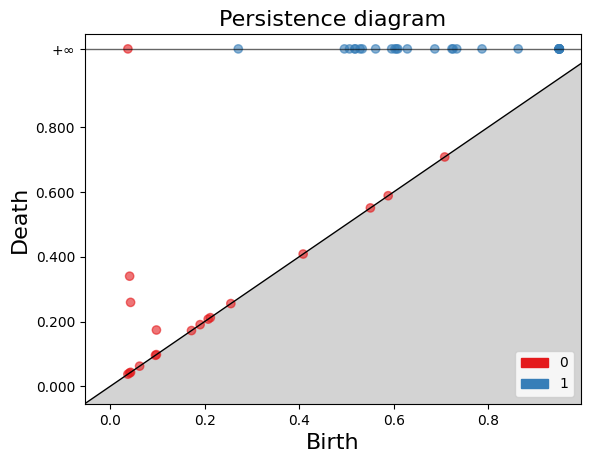

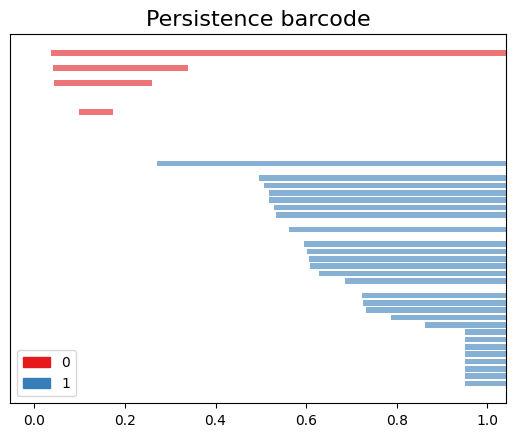

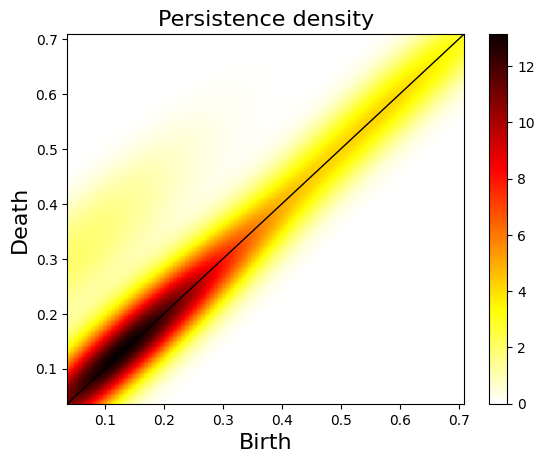

In [32]:
# Compute persistence diagrams
## NOTE: min_persistence is set to -1 to view all the simplex values (Include all 0-simplices)

# Generate persistence diagrams
diagrams = gd.plot_persistence_diagram(persistence)
barcode = gd.plot_persistence_barcode(persistence)
density = gd.plot_persistence_density(persistence)


In [33]:
rips_complex = gd.RipsComplex(distance_matrix=distance_mat, max_edge_length=1.0)

rips_simplex_tree = rips_complex.create_simplex_tree(max_dimension=3)


result_str = 'Rips complex is of dimension ' + repr(rips_simplex_tree.dimension()) + ' - ' + \
    repr(rips_simplex_tree.num_simplices()) + ' simplices - ' + \
    repr(rips_simplex_tree.num_vertices()) + ' vertices.'

print(result_str)

fmt = '%s -> %.2f'
for filtered_value in rips_simplex_tree.get_filtration():
    print(fmt % tuple(filtered_value))


Rips complex is of dimension 3 - 6195 simplices - 20 vertices.
[0] -> 0.00
[1] -> 0.00
[2] -> 0.00
[3] -> 0.00
[4] -> 0.00
[5] -> 0.00
[6] -> 0.00
[7] -> 0.00
[8] -> 0.00
[9] -> 0.00
[10] -> 0.00
[11] -> 0.00
[12] -> 0.00
[13] -> 0.00
[14] -> 0.00
[15] -> 0.00
[16] -> 0.00
[17] -> 0.00
[18] -> 0.00
[19] -> 0.00
[3, 4] -> 0.05
[4, 5] -> 0.05
[4, 8] -> 0.05
[5, 8] -> 0.05
[4, 5, 8] -> 0.05
[6, 8] -> 0.05
[6, 11] -> 0.05
[5, 17] -> 0.05
[12, 19] -> 0.05
[17, 19] -> 0.14
[0, 5] -> 0.21
[6, 17] -> 0.27
[4, 13] -> 0.27
[1, 16] -> 0.28
[3, 6] -> 0.29
[1, 9] -> 0.31
[9, 15] -> 0.37
[0, 1] -> 0.39
[10, 18] -> 0.39
[2, 17] -> 0.40
[15, 17] -> 0.40
[1, 4] -> 0.41
[10, 12] -> 0.44
[1, 11] -> 0.45
[12, 14] -> 0.47
[0, 19] -> 0.47
[14, 15] -> 0.48
[2, 18] -> 0.48
[11, 16] -> 0.49
[1, 11, 16] -> 0.49
[11, 12] -> 0.50
[11, 17] -> 0.59
[6, 11, 17] -> 0.59
[5, 19] -> 0.66
[0, 5, 19] -> 0.66
[5, 17, 19] -> 0.66
[13, 15] -> 0.73
[9, 12] -> 0.74
[2, 13] -> 0.74
[3, 5] -> 0.79
[3, 4, 5] -> 0.79
[2, 15] -> 0

In [34]:
rips_persistence = rips_simplex_tree.persistence(min_persistence=-1, persistence_dim_max=True)

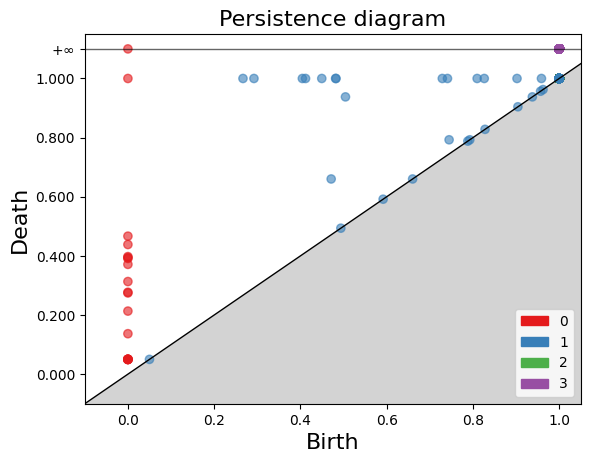

In [35]:
rips_diagram = gd.plot_persistence_diagram(rips_persistence)

In [38]:
for filtered_value in rips_simplex_tree.get_filtration():
    if len(filtered_value[0]) == 3:
        print(fmt % tuple(filtered_value))

[4, 5, 8] -> 0.05
[1, 11, 16] -> 0.49
[6, 11, 17] -> 0.59
[0, 5, 19] -> 0.66
[5, 17, 19] -> 0.66
[3, 4, 5] -> 0.79
[2, 13, 15] -> 0.79
[2, 15, 17] -> 0.79
[8, 9, 15] -> 0.83
[10, 12, 18] -> 0.90
[11, 12, 19] -> 0.94
[11, 17, 19] -> 0.94
[11, 12, 18] -> 0.96
[0, 5, 8] -> 0.96
[0, 1, 2] -> 1.00
[0, 1, 3] -> 1.00
[0, 2, 3] -> 1.00
[1, 2, 3] -> 1.00
[0, 1, 4] -> 1.00
[0, 2, 4] -> 1.00
[1, 2, 4] -> 1.00
[0, 3, 4] -> 1.00
[1, 3, 4] -> 1.00
[2, 3, 4] -> 1.00
[0, 1, 5] -> 1.00
[0, 2, 5] -> 1.00
[1, 2, 5] -> 1.00
[0, 3, 5] -> 1.00
[1, 3, 5] -> 1.00
[2, 3, 5] -> 1.00
[0, 4, 5] -> 1.00
[1, 4, 5] -> 1.00
[2, 4, 5] -> 1.00
[0, 1, 6] -> 1.00
[0, 2, 6] -> 1.00
[1, 2, 6] -> 1.00
[0, 3, 6] -> 1.00
[1, 3, 6] -> 1.00
[2, 3, 6] -> 1.00
[0, 4, 6] -> 1.00
[1, 4, 6] -> 1.00
[2, 4, 6] -> 1.00
[3, 4, 6] -> 1.00
[0, 5, 6] -> 1.00
[1, 5, 6] -> 1.00
[2, 5, 6] -> 1.00
[3, 5, 6] -> 1.00
[4, 5, 6] -> 1.00
[0, 1, 7] -> 1.00
[0, 2, 7] -> 1.00
[1, 2, 7] -> 1.00
[0, 3, 7] -> 1.00
[1, 3, 7] -> 1.00
[2, 3, 7] -> 1.00
[0, 

In [39]:
print(complex_1)

['Protein_17', 'Protein_9', 'Protein_6', 'Protein_7', 'Protein_3', 'Protein_5', 'Protein_12', 'Protein_8', 'Protein_2', 'Protein_4']


In [40]:
print(complex_2)

['Protein_13', 'Protein_15', 'Protein_20', 'Protein_18', 'Protein_17', 'Protein_5', 'Protein_6']


In [41]:
print(complex_3)

['Protein_12', 'Protein_13', 'Protein_14', 'Protein_9', 'Protein_7']


In [42]:
rips_pairs = rips_simplex_tree.persistence_pairs()
for pair in rips_pairs:
    if len(pair[0]) == 3:
        print(pair)

([3, 2, 1], [3, 2, 1, 0])
([4, 2, 1], [4, 2, 1, 0])
([4, 3, 1], [4, 3, 1, 0])
([4, 3, 2], [4, 3, 2, 0])
([5, 2, 1], [5, 2, 1, 0])
([5, 3, 1], [5, 3, 1, 0])
([5, 3, 2], [5, 3, 2, 0])
([5, 4, 1], [5, 4, 1, 0])
([5, 4, 2], [5, 4, 2, 0])
([5, 4, 0], [5, 4, 3, 0])
([6, 2, 1], [6, 2, 1, 0])
([6, 3, 1], [6, 3, 1, 0])
([6, 3, 2], [6, 3, 2, 0])
([6, 4, 1], [6, 4, 1, 0])
([6, 4, 2], [6, 4, 2, 0])
([6, 4, 3], [6, 4, 3, 0])
([6, 5, 1], [6, 5, 1, 0])
([6, 5, 2], [6, 5, 2, 0])
([6, 5, 3], [6, 5, 3, 0])
([6, 5, 4], [6, 5, 4, 0])
([7, 2, 1], [7, 2, 1, 0])
([7, 3, 1], [7, 3, 1, 0])
([7, 3, 2], [7, 3, 2, 0])
([7, 4, 1], [7, 4, 1, 0])
([7, 4, 2], [7, 4, 2, 0])
([7, 4, 3], [7, 4, 3, 0])
([7, 5, 1], [7, 5, 1, 0])
([7, 5, 2], [7, 5, 2, 0])
([7, 5, 3], [7, 5, 3, 0])
([7, 5, 4], [7, 5, 4, 0])
([7, 6, 1], [7, 6, 1, 0])
([7, 6, 2], [7, 6, 2, 0])
([7, 6, 3], [7, 6, 3, 0])
([7, 6, 4], [7, 6, 4, 0])
([7, 6, 5], [7, 6, 5, 0])
([8, 2, 1], [8, 2, 1, 0])
([8, 3, 1], [8, 3, 1, 0])
([8, 3, 2], [8, 3, 2, 0])
([8, 4, 1], 

In [43]:
len(rips_pairs)

5036

In [50]:
rips_pers_intervals = rips_simplex_tree.persistence_intervals_in_dimension(1)

In [51]:
for interval in rips_pers_intervals:
    print(interval)

[0.05 0.05]
[0.49369784 0.49369784]
[0.59174346 0.59174346]
[0.66013508 0.66013508]
[0.47127744 0.66013508]
[0.78813253 0.78813253]
[0.79265639 0.79265639]
[0.74471464 0.79265639]
[0.8279844 0.8279844]
[0.90423698 0.90423698]
[0.93771444 0.93771444]
[0.50441954 0.93771444]
[0.95683681 0.95683681]
[0.96248462 0.96248462]
[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
[0.41184789 1.        ]
[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
[0.29223972 1.        ]
[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
[0.82621786 1.        ]
[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
[0.44948925 1.        ]
[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
[0.95882691 1.        ]
[0.74093714 1.        ]
[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.]
[1. 1.